In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=column_names)

In [3]:
# Separate features and target
X = data.iloc[:, :-1].values.astype(np.float32)
y = data.iloc[:, -1].values.astype(int)  # 0 or 1 binary label

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [5]:
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class NeuralNetMLP:
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,
                              size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                              size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        return expit(z)

    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError("`how` must be 'column' or 'row'")
        return X_new

    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * np.log(output)
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad2[:, 1:] += self.l2 * w2[:, 1:]

        return grad1, grad2

    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                print(f'\rEpoch: {i + 1}/{self.epochs}', end='')

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc[:, idx], a3, self.w1, self.w2)
                self.cost_.append(cost)
                grad1, grad2 = self._get_gradient(a1, a2, a3, z2, y_enc[:, idx], self.w1, self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        if print_progress:
            print()
        return self

    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(a3, axis=0)
        return y_pred

    def predict_proba(self, X):
        _, _, _, _, a3 = self._feedforward(X, self.w1, self.w2)
        return a3.T

In [6]:
# Train model
nn = NeuralNetMLP(n_output=2,
                  n_features=X_train.shape[1],
                  n_hidden=100,
                  l2=0.1,
                  epochs=1000,
                  eta=0.1,
                  alpha=0.1,
                  decrease_const=0.00001,
                  shuffle=True,
                  minibatches=50,
                  random_state=1)

In [7]:
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1000/1000


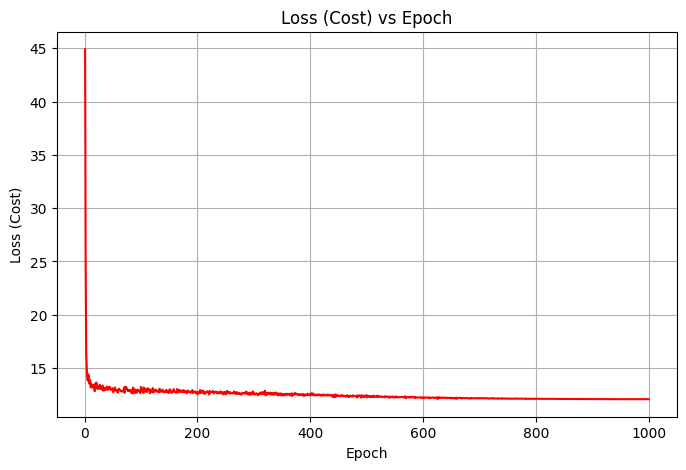

In [8]:
# Plot loss per epoch
minibatches = 50
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i*minibatches:(i+1)*minibatches]) for i in range(nn.epochs)]

plt.figure(figsize=(8,5))
plt.plot(range(1, nn.epochs+1), cost_avgs, color='red')
plt.title('Loss (Cost) vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cost)')
plt.grid()
plt.show()

In [9]:
# Predictions and evaluation
y_train_pred = nn.predict(X_train)
y_test_pred = nn.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Training accuracy: {train_acc*100:.2f}%')
print(f'Testing accuracy: {test_acc*100:.2f}%')

test_f1 = f1_score(y_test, y_test_pred)
print(f'Test F1 Score: {test_f1:.4f}')

Training accuracy: 78.83%
Testing accuracy: 75.32%
Test F1 Score: 0.6415


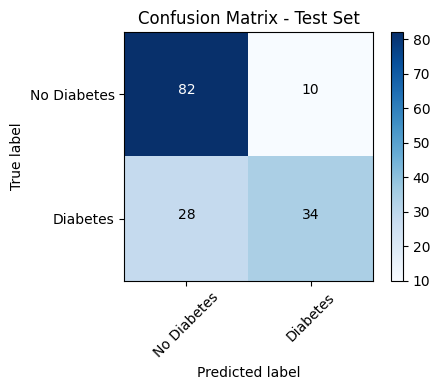

In [10]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
classes = ['No Diabetes', 'Diabetes']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

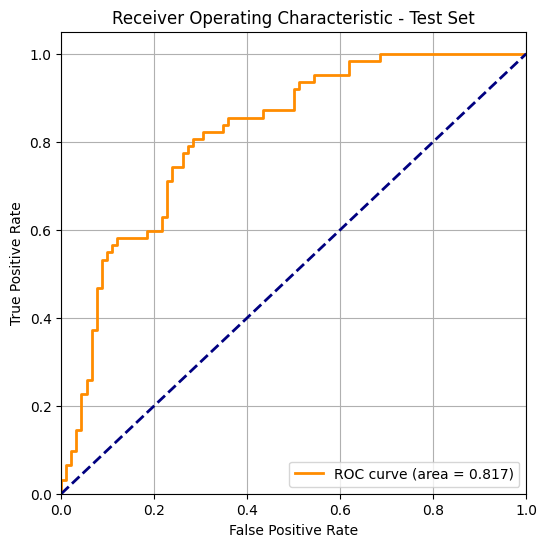

In [11]:
# ROC curve and AUC
y_test_proba = nn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [12]:
import pandas as pd
!git clone https://github.com/niaz1971/Diabetes-Dataset.git

# Load the CSV file (replace 'filename.csv' with your file path)
df = pd.read_csv('Diabetes-Dataset/diabetes.csv')
df_display = df.iloc[:10, :10].copy()
df_display.index = [''] * len(df_display)  # blank index
df_display

Cloning into 'Diabetes-Dataset'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 9.50 KiB | 9.50 MiB/s, done.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,6,148,72,35,0,33.6,0.627,50,1
,1,85,66,29,0,26.6,0.351,31,0
,8,183,64,0,0,23.3,0.672,32,1
,1,89,66,23,94,28.1,0.167,21,0
,0,137,40,35,168,43.1,2.288,33,1
,5,116,74,0,0,25.6,0.201,30,0
,3,78,50,32,88,31.0,0.248,26,1
,10,115,0,0,0,35.3,0.134,29,0
,2,197,70,45,543,30.5,0.158,53,1
,8,125,96,0,0,0.0,0.232,54,1


Predicted class for the new sample: 1


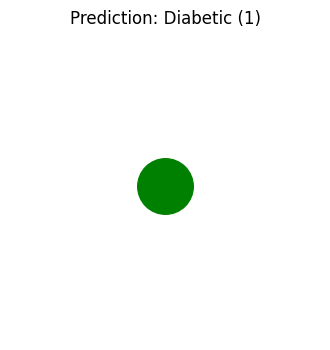

In [13]:
import numpy as np

# Define a new sample (example values for 8 features)
#new_sample = [Pregnancies ( 3 times pregnant),	Glucose (Plasma glucose concentration (158 mg/dL)),
#	BloodPressure (BloodPressure: Diastolic blood pressure (76 mm Hg)),	SkinThickness (SkinThickness: Triceps skin thickness (36 mm)),
#Insulin (Insulin: 2-hour serum insulin (245 μU/ml)),	BMI (BMI: Body mass index (31.6)),
#DiabetesPedigreeFunction (DiabetesPedigreeFunction: A diabetes pedigree function score (0.851) indicating genetic risk),
#	Age]
#new_sample = np.array([[Pregnancies,	Glucose,	BloodPressure,	SkinThickness,	Insulin,	BMI,	DiabetesPedigreeFunction,	Age]])

new_sample = np.array([[3,	158,	76,	36,	245,	31.6,	0.851,	28]])



# Scale using same scaler used in training
new_sample_scaled = scaler.transform(new_sample)

# Predict with your trained model
prediction = nn.predict(new_sample_scaled)
print(f'Predicted class for the new sample: {prediction[0]}')  # 0 = no diabetes, 1 = diabetes

import matplotlib.pyplot as plt

prediction_result = prediction[0]

plt.figure(figsize=(4, 4))

if prediction_result == 1:
    # Green circle for diabetic
    plt.plot(0.5, 0.5, marker='o', color='green', markersize=40)
    plt.title('Prediction: Diabetic (1)')
else:
    # Red cross for no diabetic
    plt.plot(0.5, 0.5, marker='x', color='red', markersize=40)
    plt.title('Prediction: No Diabetic (0)')

plt.axis('off')
plt.show()

Predicted class for the new sample: 0


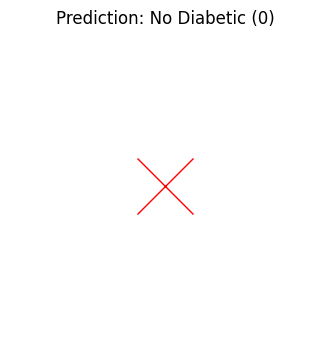

In [14]:
import numpy as np

# Define a new sample (example values for 8 features)
#new_sample = [Pregnancies ( 3 times pregnant),	Glucose (Plasma glucose concentration (158 mg/dL)),
#	BloodPressure (BloodPressure: Diastolic blood pressure (76 mm Hg)),	SkinThickness (SkinThickness: Triceps skin thickness (36 mm)),
#Insulin (Insulin: 2-hour serum insulin (245 μU/ml)),	BMI (BMI: Body mass index (31.6)),
#DiabetesPedigreeFunction (DiabetesPedigreeFunction: A diabetes pedigree function score (0.851) indicating genetic risk),
#	Age]
#new_sample = np.array([[Pregnancies,	Glucose,	BloodPressure,	SkinThickness,	Insulin,	BMI,	DiabetesPedigreeFunction,	Age]])

new_sample = np.array([[1,	85,	66,	29,	0,	26.6,	0.351,	31 ]])



# Scale using same scaler used in training
new_sample_scaled = scaler.transform(new_sample)

# Predict with your trained model
prediction = nn.predict(new_sample_scaled)
print(f'Predicted class for the new sample: {prediction[0]}')  # 0 = no diabetes, 1 = diabetes

import matplotlib.pyplot as plt

prediction_result = prediction[0]

plt.figure(figsize=(4, 4))

if prediction_result == 1:
    # Green circle for diabetic
    plt.plot(0.5, 0.5, marker='o', color='green', markersize=40)
    plt.title('Prediction: Diabetic (1)')
else:
    # Red cross for no diabetic
    plt.plot(0.5, 0.5, marker='x', color='red', markersize=40)
    plt.title('Prediction: No Diabetic (0)')

plt.axis('off')
plt.show()

Test Sensitivity (Recall): 0.5484
Test Specificity: 0.8913


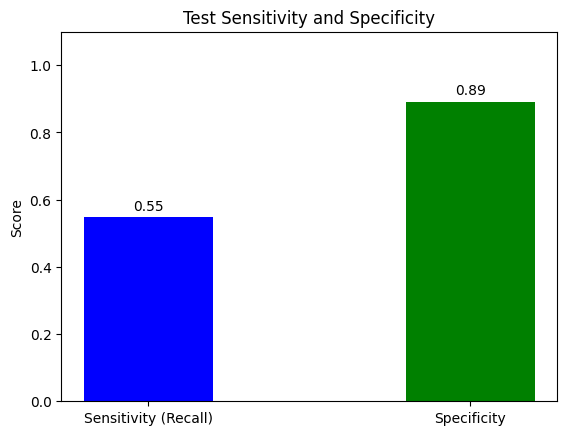

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import recall_score

# Sensitivity (Recall)
test_sensitivity = recall_score(y_test, y_test_pred)

# Specificity calculation
cm = confusion_matrix(y_test, y_test_pred)
TN = cm[0, 0]
FP = cm[0, 1]
test_specificity = TN / (TN + FP)

print(f'Test Sensitivity (Recall): {test_sensitivity:.4f}')
print(f'Test Specificity: {test_specificity:.4f}')

# Values to plot
metrics = ['Sensitivity (Recall)', 'Specificity']
values = [test_sensitivity, test_specificity]

x = np.arange(len(metrics))
width = 0.4

fig, ax = plt.subplots()
bars = ax.bar(x, values, width, color=['blue', 'green'])

ax.set_ylim(0, 1.1)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Test Sensitivity and Specificity')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

              precision    recall  f1-score   support

 No Diabetes       0.75      0.89      0.81        92
    Diabetes       0.77      0.55      0.64        62

    accuracy                           0.75       154
   macro avg       0.76      0.72      0.73       154
weighted avg       0.76      0.75      0.74       154



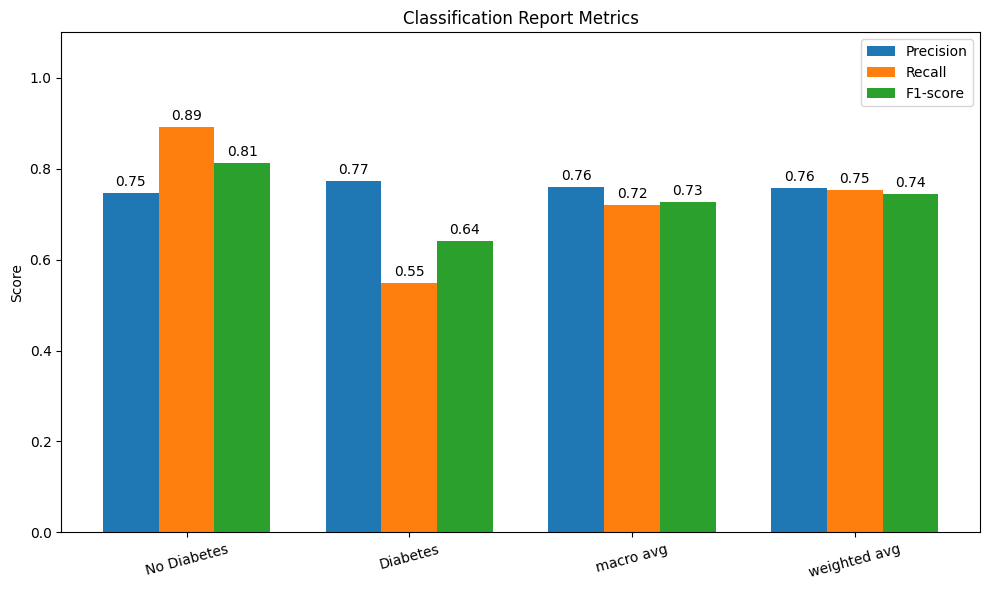

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

report = classification_report(y_test, y_test_pred, target_names=['No Diabetes', 'Diabetes'])
print(report)
# Get classification report as dictionary
report_dict = classification_report(y_test, y_test_pred, target_names=['No Diabetes', 'Diabetes'], output_dict=True)

# Define keys to extract
keys = ['No Diabetes', 'Diabetes', 'macro avg', 'weighted avg']

# Extract metrics, ignoring "accuracy" which is a float
precision = [report_dict[k]['precision'] for k in keys]
recall = [report_dict[k]['recall'] for k in keys]
f1_score = [report_dict[k]['f1-score'] for k in keys]

x = np.arange(len(keys))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=15)
ax.set_ylim(0, 1.1)
ax.set_title('Classification Report Metrics')
ax.legend()

for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()